In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,roc_curve,auc,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tools import add_constant

import warnings
warnings.filterwarnings('ignore')


In [236]:
fraud=pd.read_csv('Fraud_Data.csv')
ip=pd.read_csv('IpAddress_to_Country.csv')

In [237]:
fraud.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

In [238]:
ip.columns

Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')

In [239]:
print(" fraud data shape",fraud.shape)
print(" ip-address data shape",ip.shape)

 fraud data shape (151112, 11)
 ip-address data shape (138846, 3)


In [240]:
fraud.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [241]:
ip.isnull().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [242]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [243]:
fraud.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [244]:
ip.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

In [245]:
fraud['signup_time']=fraud['signup_time'].astype('datetime64[ns]')
fraud['purchase_time']=fraud['purchase_time'].astype('datetime64[ns]')
ip['upper_bound_ip_address']=ip['upper_bound_ip_address'].astype('float64')

In [246]:
fraud['Time Spent']=(fraud['purchase_time']-fraud['signup_time'])/np.timedelta64(1,'s')

In [247]:
country = len(fraud) * [0]

for ind, row in fraud.iterrows():
    temp = ip[(ip['lower_bound_ip_address'] < row['ip_address']) & 
           (ip['upper_bound_ip_address'] > row['ip_address'])]['country']
    
    if len(temp) == 1:
        country[ind] = temp.values[0]

fraud['country'] = country

In [248]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,Time Spent,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.80,0,4506682.00,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.87,0,17944.00,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,1.00,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91,0,492085.00,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45,0,4361461.00,United States


In [249]:
fraud.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'Time Spent', 'country'],
      dtype='object')

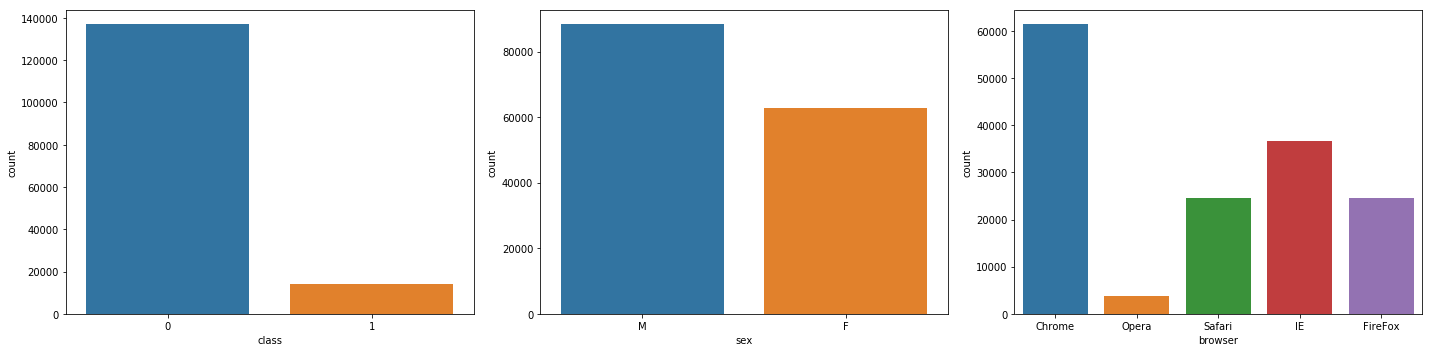

<Figure size 432x288 with 0 Axes>

In [250]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax=ax.flatten()
sns.countplot(fraud['class'],ax=ax[0])
sns.countplot(fraud['sex'],ax=ax[1])
sns.countplot(fraud['browser'],ax=ax[2])
plt.tight_layout()
plt.show()
plt.savefig('Univariate Analysis')

In [251]:
a=fraud.groupby(by=['device_id'])['user_id'].count()
b=pd.DataFrame(a).rename(columns={'user_id':'No of accounts'})
fraud=pd.merge(fraud,b,how='left',on='device_id')

In [254]:
c=fraud.groupby(by=['ip_address'])['user_id'].count()
d=pd.DataFrame(c).rename(columns={'user_id':'No of accounts per IP'})
fraud=pd.merge(fraud,d,how='left',on='ip_address')

In [255]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,Time Spent,country,No of accounts,No of accounts per IP
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.80,0,4506682.00,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.87,0,17944.00,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,1.00,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91,0,492085.00,0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45,0,4361461.00,United States,1,1


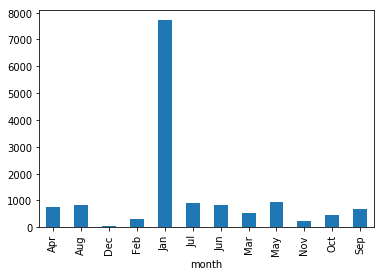

In [334]:
fraud['purchase_time']=pd.to_datetime(fraud['purchase_time'])
m=[]
for i in range(len(fraud)):
    a=fraud['purchase_time'][i].strftime('%m')
    m.append(a)
fraud['month']=m
fraud['month']=pd.to_numeric(fraud['month'])
fraud['month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace=True)
g=fraud.groupby('class')
g1=g.get_group(1)
g2=g1.groupby('month')['user_id'].count().plot(kind='bar')

In [262]:
fraud['country'].replace(0,'others',inplace=True)

In [267]:
g=fraud.groupby('country')['user_id'].count().sort_values(ascending=False)

In [273]:
cons=g[51:].index.values

In [274]:
for i in cons:
    fraud['country'].replace({i:'others'},inplace=True)
    

In [275]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,Time Spent,country,No of accounts,No of accounts per IP
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.80,0,4506682.00,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.87,0,17944.00,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11,1,1.00,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91,0,492085.00,others,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45,0,4361461.00,United States,1,1


In [276]:
df=fraud.drop(columns=['user_id','signup_time','purchase_time','device_id','ip_address'])

In [277]:
from sklearn.preprocessing import LabelEncoder

In [278]:
lm=LabelEncoder()

In [279]:
df.source=lm.fit_transform(df.source)

In [281]:
df.browser=lm.fit_transform(df.browser)
df.sex=lm.fit_transform(df.sex)
df.country=lm.fit_transform(df.country)

In [282]:
df.head()

,purchase_value,source,browser,sex,age,class,Time Spent,country,No of accounts,No of accounts per IP
0,34,2,0,1,39,0,4506682.00,25,1,1
1,16,0,0,0,53,0,17944.00,47,1,1
2,15,2,3,1,53,1,1.00,47,12,12
3,44,2,4,1,41,0,492085.00,50,1,1
4,39,0,4,1,45,0,4361461.00,47,1,1


In [284]:
X=df.drop('class',axis=1)
y=df['class']

In [285]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)

In [305]:
KNN=KNeighborsClassifier()

In [306]:
KNNmodel=KNN.fit(Xtrain,ytrain)

In [307]:
KNNpred=model.predict(Xtest)

In [308]:
accuracy_score(ytest,KNNpred)

0.9551550712489523

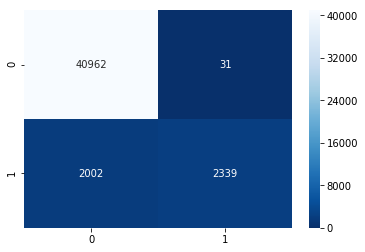

In [309]:
rf_cm = confusion_matrix(ytest,KNNpred )
sns.heatmap(rf_cm,annot=True,fmt='d',cmap='Blues_r')
plt.show()

In [322]:
RF=RandomForestClassifier()
RFmodel=RF.fit(Xtrain,ytrain)
RFpred=RF.predict(Xtest)
accuracy_score(ytest,RFpred)

0.9536330348083116

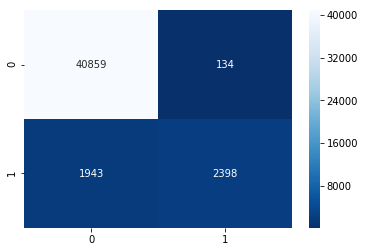

In [312]:
rf_cm = confusion_matrix(ytest,RFpred )
sns.heatmap(rf_cm,annot=True,fmt='d',cmap='Blues_r')
plt.show()

In [323]:
param_grid=({'n_estimators':[1,2,5,9,11,100],'criterion':['gini','entropy']})

In [324]:
RF_s=GridSearchCV(RF,param_grid,cv=2)
RF_s.fit(Xtrain,ytrain)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 2, 5, 9, 11, 100], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [325]:
RF_s.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [319]:
RF=RandomForestClassifier(n_estimators=100,criterion='gini')
RFmodel=RF.fit(Xtrain,ytrain)
RFpred=RF.predict(Xtest)
accuracy_score(ytest,RFpred)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

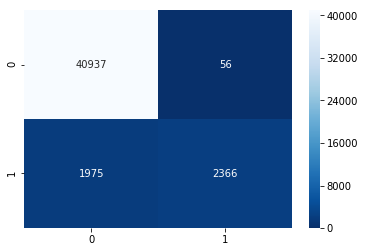

In [320]:
rf_cm = confusion_matrix(ytest,RFpred )
sns.heatmap(rf_cm,annot=True,fmt='d',cmap='Blues_r')
plt.show()

In [326]:
GB=GradientBoostingClassifier()
GBmodel=GB.fit(Xtrain,ytrain)
GBpred=GB.predict(Xtest)
accuracy_score(ytest,GBpred)

0.9557285922265849

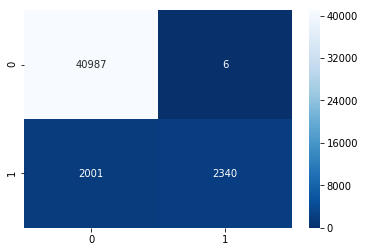

In [327]:
GB_cm = confusion_matrix(ytest,GBpred )
sns.heatmap(GB_cm,annot=True,fmt='d',cmap='Blues_r')
plt.show()

0.8253991488076526
0.8253991488076526
0.8429500492926091


(0.0, 1.1)

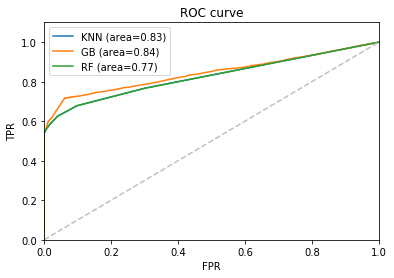

In [332]:
KNNpred_pred=KNN.predict_proba(Xtest)
RFpred_proba=RF.predict_proba(Xtest)
GBpred_proba=GB.predict_proba(Xtest)

KNNpred_pred  =KNNpred_pred[:,1]
RFpred_proba  =RFpred_proba[:,1]
GBpred_proba  =GBpred_proba[:,1]


KNNfpr,KNNtpr,thres=roc_curve(ytest,RFpred_proba)
RFfpr,RFtpr,thres=roc_curve(ytest,RFpred_proba)
GBfpr,GBtpr,thres=roc_curve(ytest,GBpred_proba)

KNNscore=auc(KNNfpr,KNNtpr)
RFscore=auc(RFfpr,RFtpr)
GBscore=auc(GBfpr,GBtpr)

print(KNNscore)
print(RFscore)
print(GBscore)


plt.plot(KNNfpr,KNNtpr,label='KNN (area=%0.2f)'%KNNscore)
plt.plot(GBfpr,GBtpr,label='GB (area=%0.2f)'%GBscore)
plt.plot(RFfpr,RFtpr,label='RF (area=%0.2f)'%lrscore)
plt.legend()


plt.plot([0,1],[0,1],color='silver',linestyle='--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0.0,1])
plt.ylim([0.0,1.1])